In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedKFold    
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

<h2>1. Data Loading</h2>

In [2]:
def mnist():
    """
    Load data with some primitive formatting
    Parameters: None
    Return: pandas dataframe object
    """
    path = '/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/Datasets/MNIST_train.csv'
    df = pd.read_csv(path)
    # a little reformatting
    df.rename(columns={'label': 'class'}, inplace=True)
    df = df.astype('int16')
    return df

<h2>2. EDA</h2>

In [3]:
# basic information
df = mnist()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, class to pixel783
dtypes: int16(785)
memory usage: 62.9 MB


In [4]:
# check missing values
df.isnull().sum().sum()

0

In [5]:
# get a sense of the target space
df['class'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int16)

In [6]:
# check if data is balanced to see if SMOTE is needed
df['class'].value_counts()
# it is quite balanced and SMOTE is not needed

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: class, dtype: int64

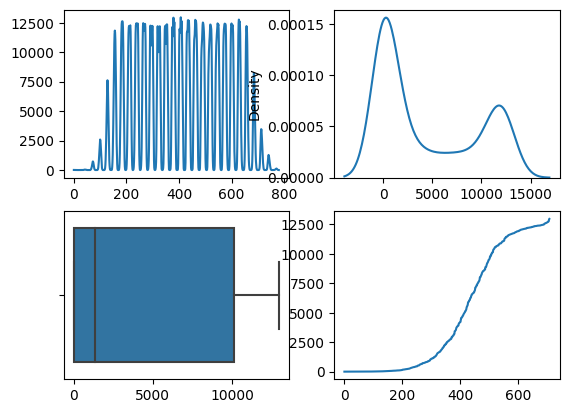

In [7]:
# plot the variance and variance distribution of non-zero values
# select only non-zero values because zero variance indicate all 0's pixel rgb value
fig, axes = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [18, 3]
x = np.where(df.var() > 0)[0]
y = np.array(df.loc[:, df.var() > 0].var())
sns.lineplot(x=x, y=y, ax=axes[0, 0])
sns.kdeplot(x=df.var(), ax=axes[0, 1])
sns.boxplot(x=df.var(), ax=axes[1, 0])
x = np.arange(0, 709)
y = sorted(np.array(df.loc[:, df.var() > 0].var()))
sns.lineplot(x=x, y=y, ax=axes[1, 1])
plt.show()

As is shown by the subplots, a lot of variances in the dataframe are small, which prevents effective classification. Therefore, I decide to use PCA to see if it helps to separate the class.

In [8]:
# select columns for PCA
X = df.loc[:, df.var() > 0].drop(columns=['class'])
y = df['class']
# scale data
scaler_model = StandardScaler()
scaler_model.fit(np.array(X))
X = scaler_model.transform(np.array(X))
# perform PCA
pca = PCA(n_components=20)
pca = pca.fit(X)
pca_arr = pca.transform(X)

In [9]:
# PCA with standardizer significantly reduces variance, which makes sense because this is what standardizing does
pca_arr.var().sum()

13.682423722448931

In [10]:
df.var().sum()

3434029.5847579027

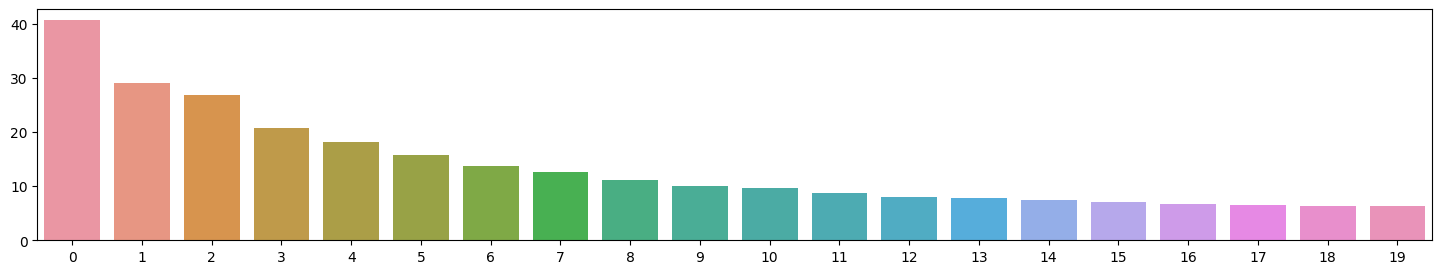

In [11]:
# plot variance of data after PCA
pca_df = pd.DataFrame(pca_arr)
fig, ax = plt.subplots(1, 1)
plt.rcParams["figure.figsize"] = [8, 2]
sns.barplot(y=pca_df.var(), x=pca_df.columns)
plt.show()

PCA returns 20 features, this bar chart visualize the variance of each PCA features, and I will examine its ability in classification below.

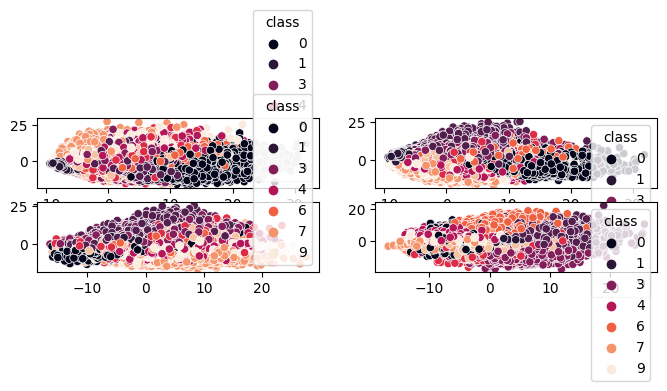

In [12]:
# plot the class distribution from PCA
fig, axes = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [12, 6]
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 1], hue=y, palette='rocket', ax=axes[0, 0], legend=True)
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 2], hue=y, palette='rocket', ax=axes[0, 1], legend=True)
sns.scatterplot(x=pca_arr[:, 1], y=pca_arr[:, 2], hue=y, palette='rocket', ax=axes[1, 0], legend=True)
sns.scatterplot(x=pca_arr[:, 2], y=pca_arr[:, 3], hue=y, palette='rocket', ax=axes[1, 1], legend=True)
plt.show()
# From the subplots, it seems that PCA performs ok: we can see some obvious separation between certain classes

<h2>3. Start to do ML</h2>
For feature engineering, I filter out data with zero variance because they indicate 0 rbg value pixels, which is rather meaningless for our purpose of classification

In [13]:
# First, construct a function that process data
def preprocessed_data(n_components=10, use_pca=True):
    """
    Preprocess the data: select features and perform PCA if specified.
    Parameters: 
        n_components: int, number of components for PCA, default=10 (optional)
        use_pca: bool, a flag determine if PCA is involved in data preprocessing, default=True (optional)
    Return: 
        [X, Y], an arry where first element is preprocessed input data, second element is preprocessed target data
    """
    df = mnist()
    # Feature selection: select only columns with positive variance for input space
    X = df.loc[:, df.var() > 0]
    y = X['class']
    X = X.drop(columns=['class'])
    # scale the data for PCA
    scaler_model = StandardScaler(with_mean=True, with_std=True)
    scaler_model.fit(np.array(X))
    X = scaler_model.transform(np.array(X))
    # do PCA
    if use_pca:
        pca = PCA(n_components=n_components)
        pca = pca.fit(X)
        X = pca.transform(X)
    return [X, y]

In [14]:
# Then, k-fold cross validation, also encapulated in a function
def model_validation(base_model=RandomForestClassifier(n_jobs=-1),selected_features='all', 
                     pca=True, n_pca=30, test_size=.4, n_splits=5, n_repeats=10, random_state=123):
    """
    Cross Validation on Models
    Parameters: 
        base_model: sklearn model object, the model to use for cross validation, 
                    default=RandomForestClassifier(n_jobs=-1)
        selected_features: string, define selected features, default='all'
        pca: bool, a flag determine if PCA is involved in data preprocessing, default=True
        n_pca: int, number of components for PCA, default=10 (optional)
        test_size: float, portion of subtesting data for train_test_split, default=0.4
        n_splits: int, number of splits for cross validation, default=10
        n_repeats: int, number of repeats of cross validation, default=10
        random_state: int, control the random assignment of train and test data for train_test_split, default=123
    Return: 
        None, only prints out and plot evaluation result of cross validation
    """
    # call preprocess_data function
    [X, y] = preprocessed_data(n_components=n_pca, use_pca=pca)
    # splitting the data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # k-fold cross-validation.
    cv = RepeatedKFold(n_splits=n_splits, random_state=123, n_repeats=n_repeats)
    splitting = cv.split(X=X_train, y=y_train)
    # create empty lists to store accuracy scores, confusion matrices, log losses
    train_accuracies = []
    test_accuracies = []
    confusion_matrices = []
    logr_tprs = []
    logr_fprs = []
    for train_index, test_index in splitting:
        X_subtraining = X_train[train_index, :]
        X_subtesting = X_train[test_index, :]
        y_subtraining = y_train.iloc[train_index]
        y_subtesting = y_train.iloc[test_index]
    # training model based on the subtraining dataset
    base_model.fit(X=X_subtraining, y=y_subtraining)
    # model validation on the substesting dataset
    y_pred = base_model.predict(X_subtesting)
    # get accuracy scores and confustion matrics
    train_accuracy = base_model.score(X=X_subtraining, y=y_subtraining)
    test_accuracy = base_model.score(X=X_subtesting, y=y_subtesting)
    test_confusion_matrix = confusion_matrix(y_true=y_subtesting, y_pred=y_pred)
    # append accuracy scores and confusion matrics to previously created lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    confusion_matrices.append(test_confusion_matrix)
    # evaluate the average scores
    ave_train_accuracy = np.mean(train_accuracies)
    ave_test_accuracy = np.mean(test_accuracies)
    ave_test_confusion_matrix = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
    # training model based on the subtesting dataset
    base_model.fit(X=X_train, y=y_train)
    y_pred = base_model.predict(X_test)
    # test accuracy score
    test_accuracy = base_model.score(X=X_test, y=y_test)
    test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # print out accuracies
    print(f"""k-fold cross-validation results:\ntrain_accuracy: {ave_train_accuracy}\ntest_accuracy: {ave_test_accuracy} """)
    print(f"""Overall test_accuracy: {test_accuracy}""")
    # plot confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    plt.rcParams["figure.autolayout"] = True
    ConfusionMatrixDisplay(ave_test_confusion_matrix).plot(ax=axes[0])
    ConfusionMatrixDisplay(test_confusion_matrix).plot(ax=axes[1])
    axes[0].set(title='Average test Confusion Matrix')
    axes[1].set(title='Test Confusion Matrix')
    plt.tight_layout()
    plt.show()

<h3>4. Evaluate the Performance of Different Models using the Cross Validation Function</h3>

<h4>4.1.1 Default - Random Forest with PCA</h4>

k-fold cross-validation results:
train_accuracy: 1.0
test_accuracy: 0.9373015873015873 
Overall test_accuracy: 0.9330357142857143


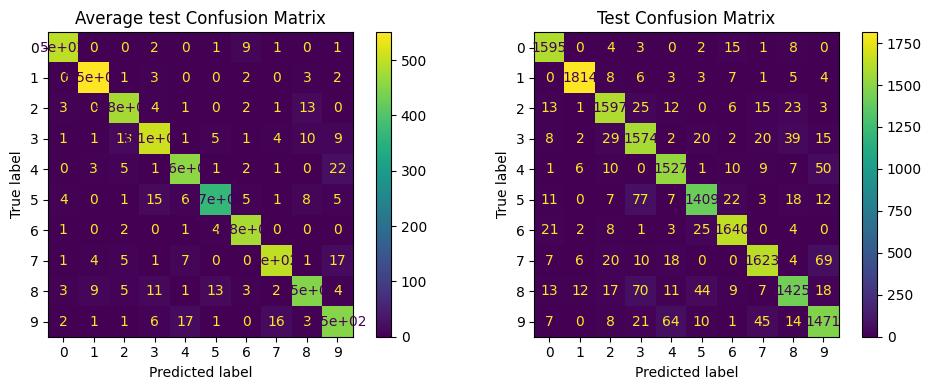

In [15]:
model_validation()

<h4>4.1.2 Random Forest without PCA</h4>

k-fold cross-validation results:
train_accuracy: 1.0
test_accuracy: 0.9628968253968254 
Overall test_accuracy: 0.9641071428571428


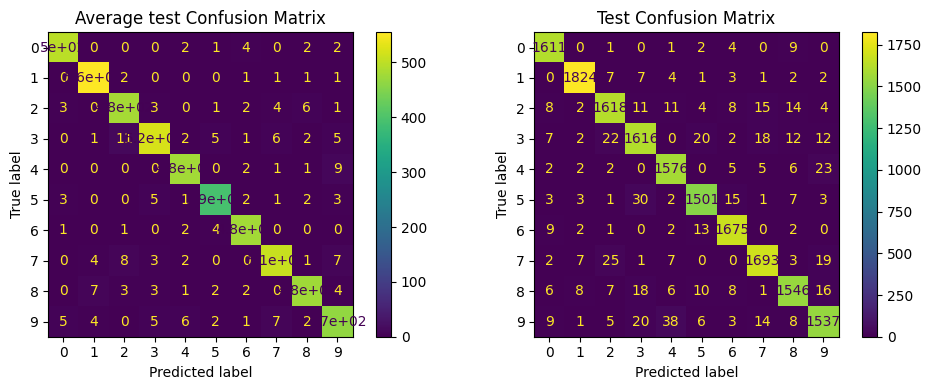

In [16]:
model_validation(pca=False)

<h4>4.2.1 Logistic Regression with PCA</h4>

k-fold cross-validation results:
train_accuracy: 0.8905357142857143
test_accuracy: 0.8885714285714286 
Overall test_accuracy: 0.8908333333333334


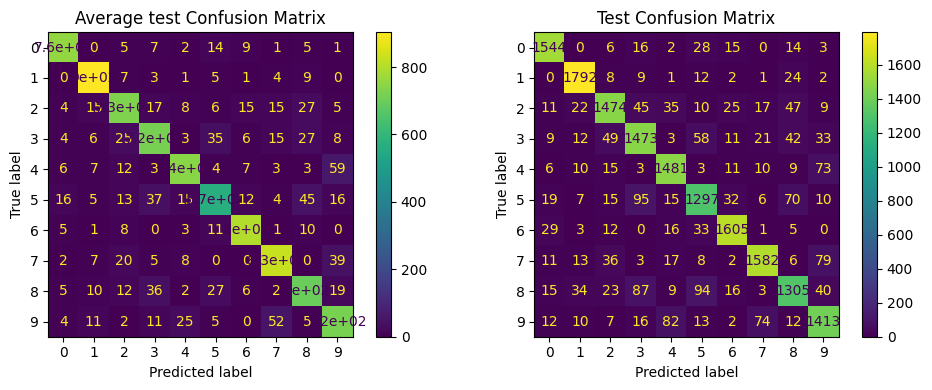

In [17]:
model_validation(base_model=LogisticRegression(n_jobs=-1, max_iter=1000),test_size=.4,n_repeats=30, n_splits=3,)

<h4>4.2.2 Logistic Regression without PCA</h4>

k-fold cross-validation results:
train_accuracy: 0.9817261904761905
test_accuracy: 0.8833333333333333 
Overall test_accuracy: 0.8998214285714285


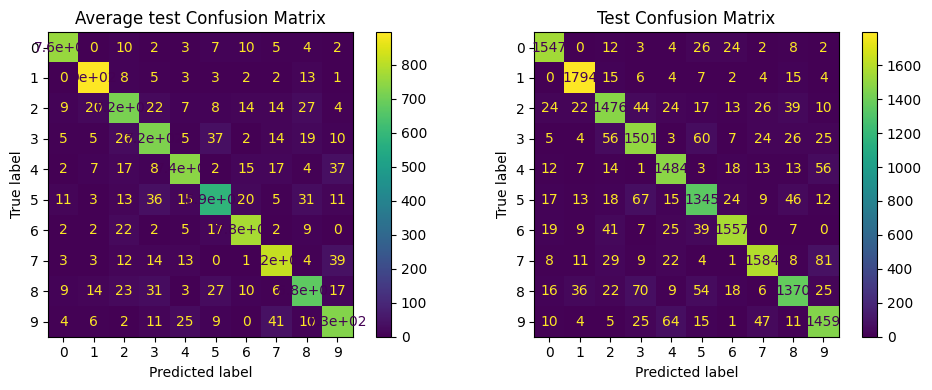

In [18]:
model_validation(base_model=LogisticRegression(n_jobs=-1, max_iter=1000),pca=False,
                 test_size=.4,n_repeats=30, n_splits=3,)

<h4>4.3.1 SVM with PCA</h4>

k-fold cross-validation results:
train_accuracy: 0.9683928571428572
test_accuracy: 0.9498214285714286 
Overall test_accuracy: 0.9571428571428572


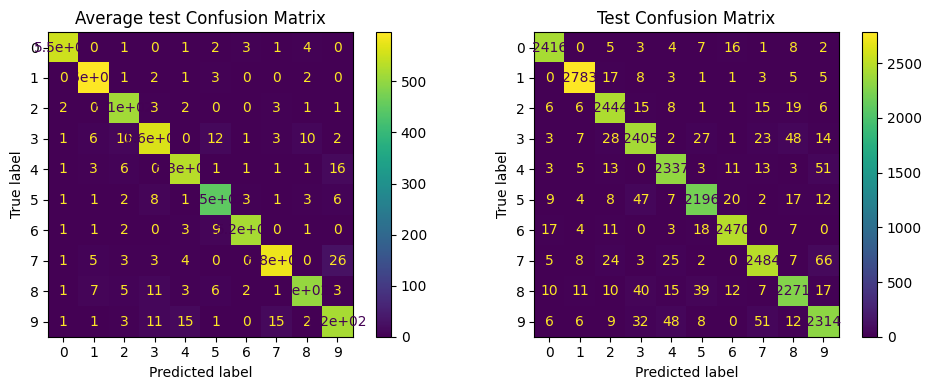

In [19]:
model_validation(base_model=SVC(max_iter=10000), test_size=.6, n_repeats=10, n_splits=3, )

<h4>4.3.2 SVM without PCA</h4>

k-fold cross-validation results:
train_accuracy: 0.98
test_accuracy: 0.9380357142857143 
Overall test_accuracy: 0.950952380952381


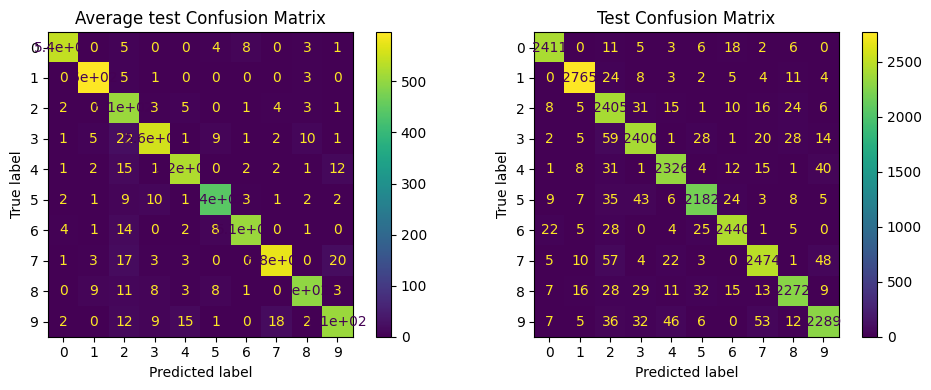

In [20]:
model_validation(base_model=SVC(max_iter=10000), pca=False, test_size=.6, n_repeats=10, n_splits=3, )

<h4>4.4.1 KNN with PCA</h4>

k-fold cross-validation results:
train_accuracy: 1.0
test_accuracy: 0.9377380952380953 
Overall test_accuracy: 0.9492261904761905


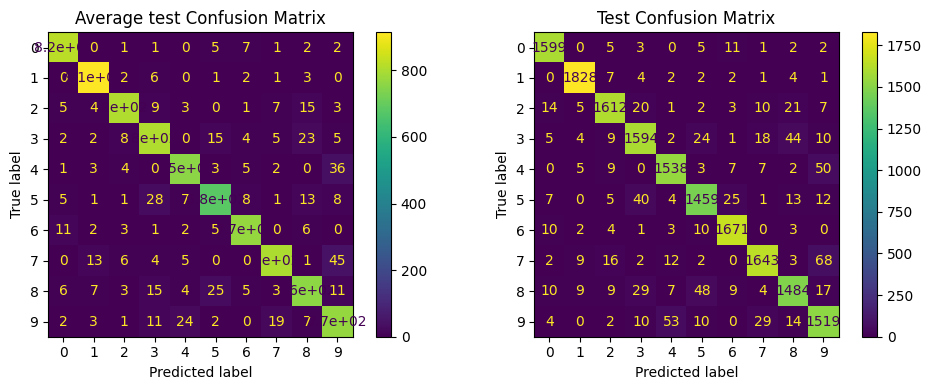

In [21]:
model_validation(base_model=KNeighborsClassifier(weights='distance'), test_size=.4, n_repeats=5, n_splits=3,)

<h4>4.4.2 KNN without PCA</h4>

k-fold cross-validation results:
train_accuracy: 1.0
test_accuracy: 0.9291666666666667 
Overall test_accuracy: 0.9366666666666666


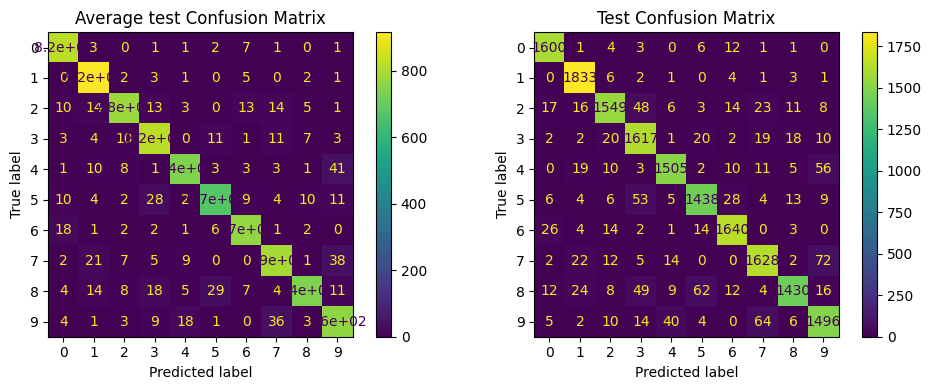

In [22]:
model_validation(base_model=KNeighborsClassifier(weights='distance'),pca=False,test_size=.4,n_repeats=5, n_splits=3,)

<h3>5. Choose a model and train using the entire training set</h3>

<h4>From the cross validation results, Random Forest without PCA performs the best on the testing dataset with over 0.96 accuracy score. However, it has training accuracy of 1.0, which may indicate overfitting. Moreovere, the lack of PCA in the better-performed Random Forest may contain excessive number of features. Therefore, I choose my model to be SVM with PCA because it has a similar testing accuracy of over 0.95. It has a reduced dimension and a training accuracy of 0.98, making it a more suitable choice of model than the Random Forest.</h4>

In [23]:
# select the model
selected_model = SVC(max_iter=10000)
# data preprocessing
[X, y] = preprocessed_data(use_pca=True, n_components=30)

In [24]:
# prepare data to train and test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
# train the model
selected_model = selected_model.fit(X=X_train, y=y_train)

In [25]:
# model evaluation
y_pred = selected_model.predict(X_test)
test_accuracy = selected_model.score(X=X_test, y=y_test)
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Test accuracy: ', test_accuracy)

Test accuracy:  0.9631547619047619


<h3>6. Further improvement on the chosen model</h3>

<h4> 6.1 Find the best set of parameters for this model using GridSearch</h5>

In [26]:
grid_of_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'C': [0.9, 0.95, 1.0]}
gscv = GridSearchCV(estimator=selected_model, param_grid=grid_of_params)
gscv.fit(X_train, y_train)
gscv.best_params_

/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your

{'C': 1.0, 'kernel': 'rbf'}

In [27]:
# Use the result from gridsearch to train an optimal model
model_best = SVC(max_iter=10000, C=1.0, kernel='rbf').fit(X=X_train, y=y_train)
# Finally, evaluate the optimal model
y_pred = selected_model.predict(X_test)
test_accuracy = selected_model.score(X=X_test, y=y_test)
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Test accuracy: ', test_accuracy)
# Seems like gridsearch cannot further improve the model - the default setting is already quite optimal

Test accuracy:  0.9631547619047619


<h4> 6.2 Change PCA settings to see if it helps the final evaluation</h4>

In [29]:
[X, y] = preprocessed_data(use_pca=True, n_components=60)
# prepare data to train and test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
# train the model
selected_model = selected_model.fit(X=X_train, y=y_train)

Test accuracy:  0.9652380952380952


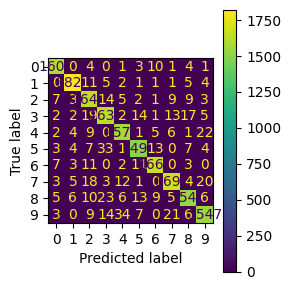

In [30]:
# model evaluation
y_pred = selected_model.predict(X_test)
test_accuracy = selected_model.score(X=X_test, y=y_test)
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Test accuracy: ', test_accuracy)
# plot confusion matrix
plt.rcParams["figure.figsize"] = [3, 3]
ConfusionMatrixDisplay(test_confusion_matrix).plot()
plt.tight_layout()
plt.show()
# Result: increasing number of component in PCA helps to increase the performance a little,
# but n_component should not be too large to prevent overfitting